<a href="https://colab.research.google.com/github/BClarke94/MSCAI/blob/main/DeepLearningCA1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
#Basic imports 
import csv
import pandas as pd
import numpy as np
from numpy import int32
import string
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from nltk import text
from keras.models import Sequential
from keras import layers
from keras.layers import LeakyReLU
import pickle
import tensorflow as tf
keras = tf.keras 
from sklearn.model_selection import train_test_split

#Removal of stopwords
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = stopwords.words('english')

#Stemming the words
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

#For vectorizing text
from sklearn.feature_extraction.text import CountVectorizer


#Resampling imports
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from collections import Counter

#Packages for CNN
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

#Importing packages for RNN-LSTM model 
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
import seaborn as sns
%matplotlib inline

#Filter Warnings
import warnings as wrn
wrn.filterwarnings('ignore')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Data Preperation

In [ ]:
df = pd.read_csv("politicalLean.csv",index_col=0)
df =df.reset_index()
print("Total Number of Rows in dataset: " + str(len(df.index)))
print("---")
print(df.isnull().sum())
#Selecting only the title and political leaning for classification
df = df[['Title', 'Political Lean']]
print("---")
print(df['Title'].map(lambda x: len(x)).max())
print("---")
print(df.isnull().sum())


Total Number of Rows in dataset: 12854
---
Title                  0
Political Lean         0
Score                  0
Id                     0
Subreddit              0
URL                    0
Num of Comments        0
Text               10426
Date Created           0
dtype: int64
---
300
---
Title             0
Political Lean    0
dtype: int64


## Function Creation

In [ ]:
def dataPrep(dataframe, lower):
  #Checking for null values
  

  dataframe.loc[df['Political Lean'] == "Liberal", 'Political Lean'] = 0
  dataframe.loc[df['Political Lean'] == "Conservative", 'Political Lean'] = 1

  #Removing Stopwords, punctuation and moving all letters to lowercase
  dataframe['Title'] = dataframe['Title'].apply(lambda x:x.translate(str.maketrans('', '',string.punctuation)))
  dataframe['Title'] = dataframe['Title'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

  if lower == 1:
    dataframe['Title'] = dataframe['Title'].apply(lambda x:x.lower())
  #else:  
    #print(dataframe['Title'][0])
    #dataframe['Title'] = dataframe['Title'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    #print(dataframe['Title'][0])
    #dataframe['Title'] = dataframe['Title'].apply(lambda x: [stemmer.stem(y) for y in x])
    #print(dataframe['Title'][0])
  X = dataframe['Title']

  y = dataframe['Political Lean']
  y = np.asarray(y).astype('float32')
  return(X, y)

In [ ]:
#Creating a function for plotting ouput data of model later
def plotCheck(history):
  print(history.history.keys())
  # summarize history for accuracy
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()



In [ ]:
def prediction_Output(predictions):
  prediction_res = np.mean(predictions) 
  if prediction_res < .5:
    prediction = "Likely Written by a Liberal"
  else:
    prediction = "Likely Written by a Republican"
  return prediction

In [ ]:
df.value_counts('Political Lean')

Political Lean
Liberal         8319
Conservative    4535
dtype: int64

In [ ]:
X, y = dataPrep(df, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1000)

df['Title'][0]

'no matter someone look like language speak wear remember human for sake humanity working class must unite across arbitrary boundaries'

Undersampling to reduce Computational Cost 

In [ ]:
def underSamp(X_train, X_test, y_train, y_test, model):
  X_train1 = X_train.to_numpy()
  X_test1 = X_test.to_numpy()

  under_sampler = RandomUnderSampler(random_state=420)
  X1 = X_train1.reshape(-1, 1)
  y1 = y_train.reshape(-1, 1)
  X_test1 = X_test1.reshape(-1, 1)
  y_test1 = y_test.reshape(-1, 1)

  X_under, y_train_under = under_sampler.fit_resample(X1, y1)
  X_test_under, y_test_under = under_sampler.fit_resample(X_test1, y_test1)
  if model == 'CNN':
    X_under = X_under.tolist()
    X_test_under = X_test_under.tolist()
    

  print(f"Training target statistics: {Counter(y_train_under)}")
  print(f"Testing target statistics: {Counter(y_test_under)}")
  return X_under, y_train_under, X_test_under, y_test_under

In [ ]:
def overSamp(X_train, X_test, y_train, y_test, model):
  X_train1 = X_train.to_numpy()
  X_test1 = X_test.to_numpy()

  over_sampler = RandomOverSampler(random_state=420)
  X1 = X_train1.reshape(-1, 1)
  y1 = y_train.reshape(-1, 1)
  X_test1 = X_test1.reshape(-1, 1)
  y_test1 = y_test.reshape(-1, 1)

  X_over, y_train_over = over_sampler.fit_resample(X1, y1)
  X_test_over, y_test_over = over_sampler.fit_resample(X_test1, y_test1)
  if model == 'CNN':
    X_over = X_over.tolist()
    X_test_over = X_test_over.tolist()
    

  print(f"Training target statistics: {Counter(y_train_over)}")
  print(f"Testing target statistics: {Counter(y_test_over)}")
  return X_over, y_train_over, X_test_over, y_test_over

# ANN MODEL

In [ ]:
#Preparing the data for transformation into vectorized data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1000)

X_under, y_train_under, X_test_under, y_test_under = underSamp(X_train, X_test, y_train, y_test, 'ANN')

#X_over, y_train_over, X_test_over, y_test_over = overSamp(X_train, X_test, y_train, y_test, 'ANN')

X_under =X_under.flatten(order='C')
X_under = pd.Series(X_under)

X_test_under =X_test_under.flatten(order='C')
X_test_under = pd.Series(X_test_under)

#Count Vectorization fitting
count_vect = CountVectorizer()
count_vect.fit(X_under)

#Bigram vecotrization fitting
bigram_vectorizer = CountVectorizer(ngram_range=(1, 3), token_pattern=r'\b\w+\b', min_df=1)
bigram_vectorizer.fit(X_under)

#Creating the sparse matrix's from this data
X_train_COUNT = count_vect.transform(X_under)
X_test_COUNT  = count_vect.transform(X_test_under)

X_train_BIGRAM = bigram_vectorizer.transform(X_under)
X_test_BIGRAM = bigram_vectorizer.transform(X_test_under)


Training target statistics: Counter({0.0: 3376, 1.0: 3376})
Testing target statistics: Counter({0.0: 1159, 1.0: 1159})


In [ ]:

textVec = X_train_BIGRAM
textVec_test = X_test_BIGRAM

input_dim = textVec.shape[1]  # Number of features
#input_dim = X_train_COUNT.shape[1] 

model_ANN = Sequential()
model_ANN.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
#model.add(layers.Dense(10, input_dim=65420, activation='sigmoid'))
model_ANN.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model_ANN.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model_ANN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                1050070   
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,050,081
Trainable params: 1,050,081
Non-trainable params: 0
_________________________________________________________________


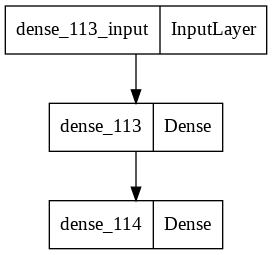

In [ ]:
tf.keras.utils.plot_model(model_ANN)

In [ ]:
history = model_ANN.fit(textVec, y_train_under,
                    #validation_split=0.33,
                    epochs=6,
                    verbose=False,
                    validation_data=(textVec_test, y_test_under),
                    batch_size=100)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


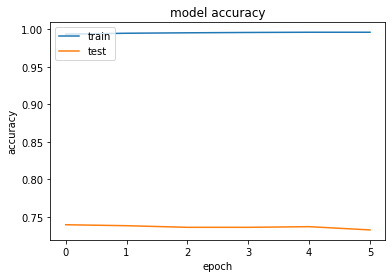

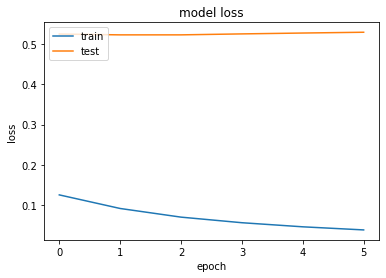

Training Accuracy: 0.9969
Testing Accuracy:  0.7325


In [ ]:
plotCheck(history)

#Checking general accuracy of the model after training 
loss, accuracy1 = model_ANN.evaluate(textVec, y_train_under, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy1))

loss, accuracy2 = model_ANN.evaluate(textVec_test, y_test_under, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy2))

## Prediction:
ANN model

In [ ]:
pred_Lib = "Voting machine maker wins appeal in GOP election inquiry"
pred_Con = "Bill Barr Urges Republicans to Pick an ‘Impressive’ and ‘Younger’ 2024 Nominee Instead of Trump"
pred_Con2 = 'After a lot of research, it appears that their excuse for this is closing the income and generational wealth gap between whites, minorities and “undocumented migrants”'

for i in [pred_Lib, pred_Con, pred_Con2]:
  tokenized_ann = i.split(" ")
  X_pred_bi = bigram_vectorizer.transform(tokenized_ann)
  predictions = model_ANN.predict(X_pred_bi)

  print(prediction_Output(predictions))


Likely Written by a Liberal
Likely Written by a Republican
Likely Written by a Republican


# CNN Model

In [ ]:
X, y = dataPrep(df, 0)
scaler = MinMaxScaler(feature_range=(0, 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
#X_under_CNN, y_train_under, X_test_under_CNN, y_test_under = underSamp(X_train, X_test, y_train, y_test, 'CNN')
#X_over, y_train_over, X_test_over, y_test_over = overSamp(X_train,X_test,y_train,y_test, 'CNN')

tokenizer = Tokenizer(num_words=300, lower=False)
tokenizer.fit_on_texts(X_train)


#tokenizer.fit_on_texts(X_train)

X_train1 = tokenizer.texts_to_sequences(X_train)
X_test1= tokenizer.texts_to_sequences(X_test)


In [ ]:
input_dim = len(tokenizer.word_index) + 1
embedding_dim = 50
maxlen = 30

X_train_CNN = pad_sequences(X_train1, padding='pre', maxlen=maxlen)
X_test_CNN = pad_sequences(X_test1, padding='pre', maxlen=maxlen)

X_train_CNN = scaler.fit_transform(X_train_CNN)
X_test_CNN = scaler.fit_transform(X_test_CNN)

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.0001)
model_CNN = Sequential()
model_CNN.add(layers.Embedding(input_dim=input_dim, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model_CNN.add(layers.Dense(20, activation='sigmoid'))
model_CNN.add(Dropout(0.5))
model_CNN.add(layers.Flatten(data_format = None))
model_CNN.add(layers.Dense(20, activation='sigmoid'))
model_CNN.add(layers.Dense(1, activation='sigmoid'))

model_CNN.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])
model_CNN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 50)            811900    
                                                                 
 dense_2 (Dense)             (None, 30, 20)            1020      
                                                                 
 dropout (Dropout)           (None, 30, 20)            0         
                                                                 
 flatten (Flatten)           (None, 600)               0         
                                                                 
 dense_3 (Dense)             (None, 20)                12020     
                                                                 
 dense_4 (Dense)             (None, 1)                 21        
                                                                 
Total params: 824,961
Trainable params: 824,961
Non-tr

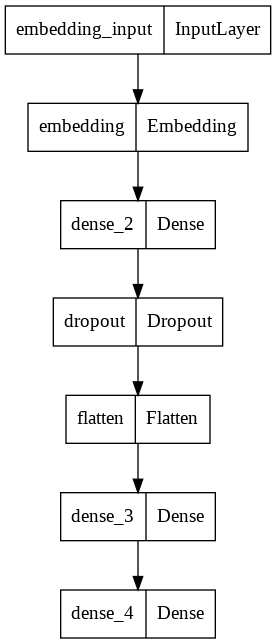

In [ ]:
tf.keras.utils.plot_model(model_CNN)

In [ ]:
history = model_CNN.fit(X_train_CNN, y_train,
                    epochs=10,
                    verbose=False,
                    validation_data=(X_test_CNN, y_test),
                    batch_size=100)


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


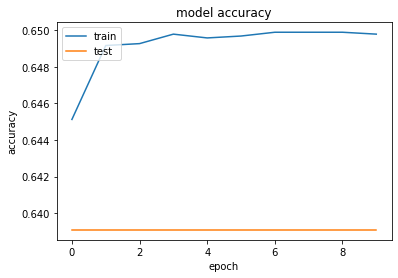

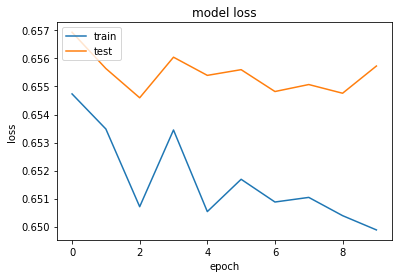

Training Accuracy: 0.6499
Testing Accuracy:  0.6391


In [ ]:
plotCheck(history)

loss, accuracy = model_CNN.evaluate(X_train_CNN, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_CNN.evaluate(X_test_CNN, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

## Prediction:

CNN Model

In [ ]:
pred_Lib = "Voting machine maker wins appeal in GOP election inquiry"
pred_Con = "Bill Barr Urges Republicans to Pick an ‘Impressive’ and ‘Younger’ 2024 Nominee Instead of Trump"
pred_Con2 = 'After a lot of research, it appears that their excuse for this is closing the income and generational wealth gap between whites, minorities and “undocumented migrants”'

for i in [pred_Lib, pred_Con, pred_Con2]:
  X_train1 = tokenizer.texts_to_sequences(i)
  X_pred_cnn = pad_sequences(X_train1, padding='post', maxlen=maxlen)
  predictions = model_CNN.predict(X_pred_cnn)
  #predictions = predictions.reshape(1, 1)
  #predictions = scaler.inverse_transform(np.mean(predictions))
  

  print(prediction_Output(predictions))

Likely Written by a Liberal
Likely Written by a Liberal
Likely Written by a Liberal


# LSTM Model: 

In [ ]:
X, y = dataPrep(df, 0)




In [ ]:
le = LabelEncoder()
y = le.fit_transform(y)
y = y.reshape(-1,1)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25, random_state=40)

#X_over, y_train_over, X_test_over, y_test_over = overSamp(X_train,X_test,y_train,y_test, 'CNN')


In [ ]:
max_words = 3500
max_len = 300

textVec_LSTM = X_train
textVec_LSTM_test = X_test
y_train_textVec = y_train
y_test_textVec = y_test

token = Tokenizer(num_words=max_words)
token.fit_on_texts(textVec_LSTM)

sequences = token.texts_to_sequences(textVec_LSTM)
X_train_LSTM = sequence.pad_sequences(sequences,maxlen=max_len)

test_sequences = token.texts_to_sequences(textVec_LSTM_test)
X_test_LSTM = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [ ]:
X_test_LSTM

array([[   0,    0,    0, ..., 1675,   64,  917],
       [   0,    0,    0, ...,    6,   16,  204],
       [   0,    0,    0, ...,  480,  839,  712],
       ...,
       [   0,    0,    0, ..., 3328,    6,  371],
       [   0,    0,    0, ..., 3079,  911,    1],
       [   0,    0,    0, ...,  941,   46,   39]], dtype=int32)

In [ ]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [ ]:
model_LSTM = RNN()
model_LSTM.summary()
model_LSTM.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 300)]             0         
                                                                 
 embedding_3 (Embedding)     (None, 300, 50)           175000    
                                                                 
 lstm_3 (LSTM)               (None, 64)                29440     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 activation_6 (Activation)   (None, 256)               0         
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 257 

In [ ]:
#tf.keras.utils.plot_model(model_LSTM)


In [ ]:
history = model_LSTM.fit(X_train_LSTM,
                    y_train_textVec,
                    batch_size=100,
                    epochs=30,
                    validation_split=0.2,
                    callbacks=[EarlyStopping(monitor='val_loss',
                                             min_delta=0.0001)])


Epoch 1/30
78/78 [==============================] - 23s 299ms/step - loss: 0.9256 - accuracy: 0.7184 - val_loss: 0.5279 - val_accuracy: 0.7334
Epoch 2/30
78/78 [==============================] - 23s 293ms/step - loss: 0.4254 - accuracy: 0.8047 - val_loss: 0.5143 - val_accuracy: 0.7588


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


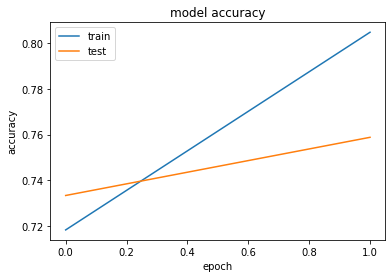

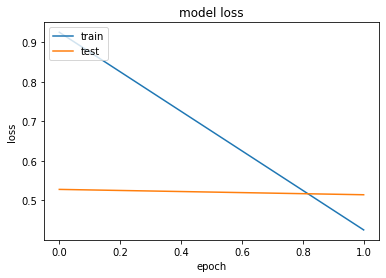

Training Accuracy: 0.8265
Testing Accuracy:  0.7330


In [ ]:
plotCheck(history)

loss, accuracy = model_LSTM.evaluate(X_train_LSTM, y_train_textVec, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_LSTM.evaluate(X_test_LSTM, y_test_textVec, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

## Prediction:
LSTM Model

In [ ]:
pred_Lib = "Voting machine maker wins appeal in GOP election inquiry"
pred_Con = "Bill Barr Urges Republicans to Pick an ‘Impressive’ and ‘Younger’ 2024 Nominee Instead of Trump"
pred_Con2 = 'After a lot of research, it appears that their excuse for this is closing the income and generational wealth gap between whites, minorities and “undocumented migrants”'

for i in [pred_Lib, pred_Con, pred_Con2]:
  test_sequences_Pred = token.texts_to_sequences(i)
  test_sequences_matrix = sequence.pad_sequences(test_sequences_Pred,maxlen=max_len)

  predictions = model_LSTM.predict([test_sequences_matrix])

  print(prediction_Output(predictions))




Likely Written by a Liberal
Likely Written by a Liberal
Likely Written by a Liberal


In [ ]:
test_sequences_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 4],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

# Final Artifact:


In [ ]:
filename = 'finalized_model_ANN.sav'
pickle.dump(model_ANN, open(filename, 'wb'))

INFO:tensorflow:Assets written to: ram://0e251571-fc5b-43fa-95f5-4c8ebaf5d619/assets
